# Titanic Data Science

## Libraries

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

## Data Analysis

In [94]:
df1 = pd.read_csv('./input/train.csv')
df2 = pd.read_csv('./input/test.csv')

df = pd.concat([df1, df2], ignore_index=True)
df.set_index('PassengerId', inplace=True)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Features Description
__PassengerId:__ ID assigned to each passenger\
__Survived:__ Target column (0 = No, 1 = Yes)\
__Pclass:__	Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)\
__Name:__ Name of the passenger\
__Sex:__ Gender of the passenger\
__Age:__ Age of the passenger in years\
__Sibsp:__ Number of siblings/spouses aboard with the passenger\
__Parch:__	Number of parents/children aboard with the passenger\
__Ticket:__	Ticket number\
__Fare:__ Passenger fare\
__Cabin:__ Cabin number\
__Embarked:__ Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

_Extra Notes:_ \
__Age__ is fractional if less than 1. If it is estimated, is it in the form of xx.5\
__Sibsp__ includes brother, sister, stepbrother and stepsister\
__Spouse__ includes husband and wife (mistresses and fiancés were ignored)


## Extra

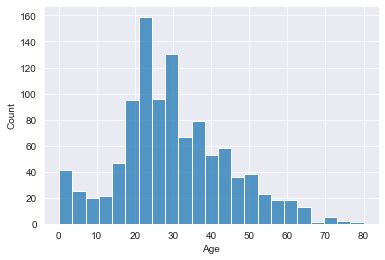

In [95]:
sns.histplot(data=df, x='Age')

### Dealing with missing data

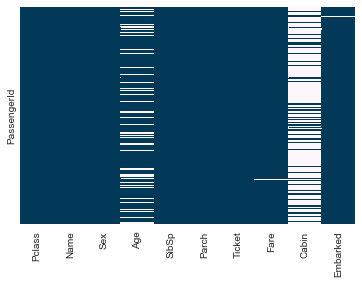

In [96]:
sns.heatmap(df.drop('Survived', axis=1).isnull(), cbar=False, cmap='PuBu_r', yticklabels=False)

In [97]:
df.drop('Survived', axis=1).isnull().sum()

Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

The missing values are:
* 1014 in Cabin (77.46%)
* 263 in Age (20.01%)
* 2 in Embarked (0.001%)
* 1 in Fare (0.0007%)

#### Let's fill in the missing values

* _Cabin_

![image](./img/titanic1.png)

Titanic's colision was on the Forepeak, therefore Cabin A, B and C were the first ones to fill up. This is important information in order to predict survival rate.\
The only feature I would consider that it correlates with cabin is ticket so let's try to fill the Cabin missig values with Ticket.

In [98]:
df['Cabin'] = df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else x)
df['Cabin'].value_counts()

C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: Cabin, dtype: int64

In [99]:
df['Ticket'].apply(lambda x: x.split()[0]).nunique()

755

In [100]:
df[['Cabin', 'Ticket']].dropna()

,Cabin,Ticket
PassengerId,,
2,C,PC 17599
4,C,113803
7,E,17463
11,G,PP 9549
12,C,113783
...,...,...
1296,D,17765
1297,D,SC/PARIS 2166
1299,C,113503


The percentage of missing data in Cabin is significant and there is no obvious relation to Ticket therefore filling up those missing values could damage our model rather than improve it. Therefore, both the Cabin and Ticket columns will be dropped.

In [101]:
df.drop(['Cabin', 'Ticket'], axis=1, inplace=True)

* _Embarked_

In [102]:
df[df['Embarked'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,,
62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN
830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN


After some online research I found that both Amelie and Martha embarked the Titanic on Southampton

https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html \
https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html 

In [103]:
df['Embarked'] = df['Embarked'].fillna('S')

* _Fare_

In [104]:
df[df['Fare'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,,
1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,NaN,S


The person missing the Fare value is a male in the 60s (remember .5 means the age was approximated) and has a 3rd class ticket

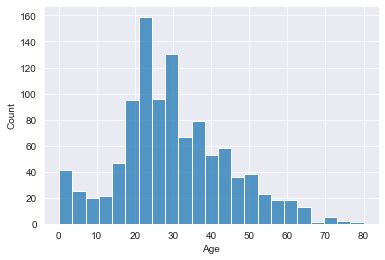

In [105]:
sns.histplot(df['Age'])

Let's take the median of all the male passengers with a 3rd class ticket between 50 ans 70 years old

In [106]:
mdn = df[(df['Pclass'] == 3) & (df['Sex'] == 'male') & (df['Age'] >= 50) & (df['Age'] <= 70)]['Fare'].mean()
df['Fare'] = df['Fare'].fillna(mdn)

print('Median {}'.format(mdn))

Median 8.299077777777777


* _Age_

Many values are missing the feature Age so we need to find a more complex method to fill those values.\
The only feature I believe correlates with Age is the Title, which is currently inaccessible on the Name column.

In [107]:
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df.drop('Name', axis=1, inplace=True) #I doubt the particular name of each passenger will be useful in the future

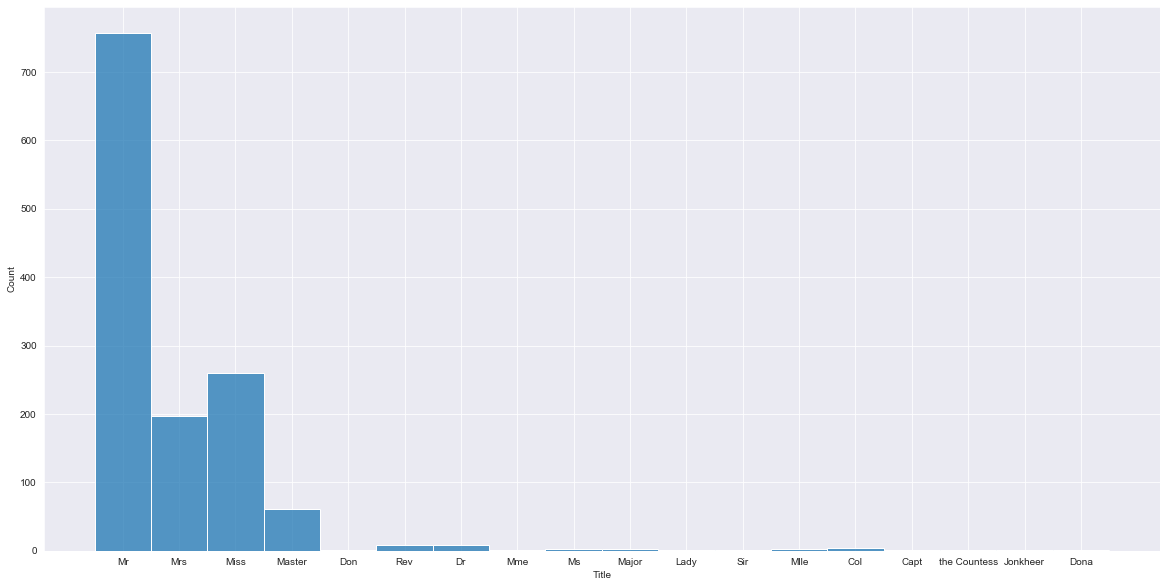

In [108]:
plt.figure(figsize=(20,10))
sns.histplot(df['Title'], )

As we can see in this plot, there are many titles with a low frequency. \
Let's join them under a more general name.
It is important to note this will be used to predict age so the grouping should take that in account.

In [109]:
df['Title'] = df['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Rev', 'the Countess'], 'Prestigious title')
df['Title'] = df['Title'].replace(['Master'], 'Young man')
df['Title'] = df['Title'].replace(['Miss', 'Mme', 'Lady', 'Mlle'], 'Young woman')
df['Title'] = df['Title'].replace(['Mr', 'Don'], 'Middle-aged man')
df['Title'] = df['Title'].replace(['Mrs', 'Ms', 'Dona'], 'Middle-aged woman')

In [110]:
median = df.groupby(['Title']).median()['Age']
median_dict = pd.Series(median.values,index=median.index).to_dict()

In [111]:
mask = df['Age'].isnull()
df.loc[mask, 'Age'] = df.loc[mask, 'Title'].map(median_dict)

### Understanding the data

__Useful information deducted from the following figures__

* The total samples are 891, which is 40% of the 2224 actual passengers (#1)
* Priority was given for class 1 passengers, followed by class 2 and a lowest survival rate for class 3 (#2) 
* Priority was given to women during the disembarkment of the Titanic. _Interesting note:_ Younger girls have the lowest survival rate while younger boys have the highest among their respective graphs. (#3)
* The majority of passengers did not travel with family members, Parch and SibSp have very similar distributions (#4)
* Southampton was the most common embarking station (#5)

In [112]:
#1
df.info()
print('_'*40)  
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   object 
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1309 non-null   float64
 7   Embarked  1309 non-null   object 
 8   Title     1309 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 102.3+ KB
________________________________________


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.383838,2.294882,29.438251,0.498854,0.385027,33.276383
std,0.486592,0.837836,13.164775,1.041658,0.865560,51.743492
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,29.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.500000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


62.96% of passengers in class 1 survived
47.28% of passengers in class 2 survived
24.24% of passengers in class 3 survived


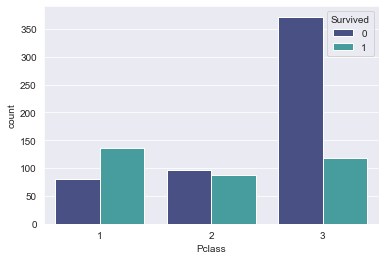

In [113]:
#2
sns.countplot(data=df1, x='Pclass', palette='mako', hue='Survived')
for i in range(1, 4):
    print('{}% of passengers in class {} survived'.format(round(df1[(df1['Pclass'] == i) & (df1['Survived'] == 1)].count()[0] / df1[df1['Pclass'] == i].count()[0]*100, 2), i))
    

In [114]:
#3.1
cut_bins = [0, 15, 20, 25, 30, 40, 50, 60, 100]
df['Age_cuts'] = pd.cut(df['Age'], bins=cut_bins, right=False)

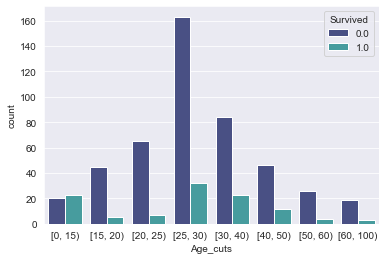

In [115]:
#3.2
sns.countplot(data=df[df['Sex'] == 'male'], x='Age_cuts', palette='mako', hue='Survived')

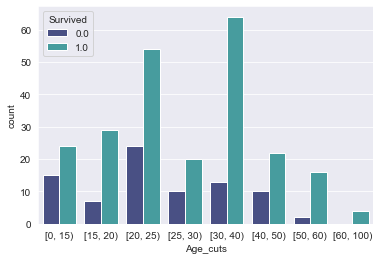

In [116]:
#3.3
sns.countplot(data=df[df['Sex'] == 'female'], x='Age_cuts', palette='mako', hue='Survived')

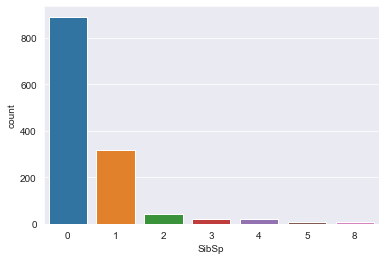

In [117]:
#4.1
sns.countplot(data=df, x='SibSp')

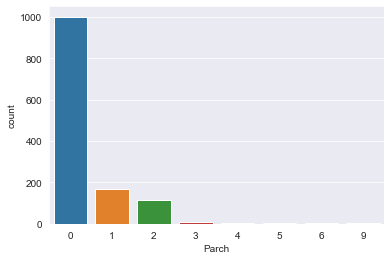

In [118]:
#4.2
sns.countplot(data=df, x='Parch')

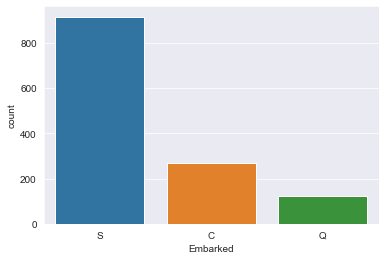

In [119]:
#5
sns.countplot(data=df, x='Embarked')

### Preprocessing the data

On this step, I will convert all categorical columns to numerical ones and join the continuous columns into intervals

In [120]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [121]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_cuts
PassengerId,,,,,,,,,,
1,0.0,3,male,22.0,1,0,7.2500,S,Middle-aged man,"[20, 25)"
2,1.0,1,female,38.0,1,0,71.2833,C,Middle-aged woman,"[30, 40)"
3,1.0,3,female,26.0,0,0,7.9250,S,Young woman,"[25, 30)"
4,1.0,1,female,35.0,1,0,53.1000,S,Middle-aged woman,"[30, 40)"
5,0.0,3,male,35.0,0,0,8.0500,S,Middle-aged man,"[30, 40)"
...,...,...,...,...,...,...,...,...,...,...
1305,NaN,3,male,29.0,0,0,8.0500,S,Middle-aged man,"[25, 30)"
1306,NaN,1,female,39.0,0,0,108.9000,C,Middle-aged woman,"[30, 40)"
1307,NaN,3,male,38.5,0,0,7.2500,S,Middle-aged man,"[30, 40)"


* _Pclass_

In [122]:
onehot = OneHotEncoder(drop='first')
onehot_pclass = pd.DataFrame(onehot.fit_transform(df[['Pclass']], ).toarray(), index=range(1,1310), columns=['Pclass3', 'Pclass2'])
df = df.join(onehot_pclass)
df.drop('Pclass', axis=1, inplace=True)

In [123]:
df

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age_cuts,Pclass3,Pclass2
PassengerId,,,,,,,,,,,
1,0.0,male,22.0,1,0,7.2500,S,Middle-aged man,"[20, 25)",0.0,1.0
2,1.0,female,38.0,1,0,71.2833,C,Middle-aged woman,"[30, 40)",0.0,0.0
3,1.0,female,26.0,0,0,7.9250,S,Young woman,"[25, 30)",0.0,1.0
4,1.0,female,35.0,1,0,53.1000,S,Middle-aged woman,"[30, 40)",0.0,0.0
5,0.0,male,35.0,0,0,8.0500,S,Middle-aged man,"[30, 40)",0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,male,29.0,0,0,8.0500,S,Middle-aged man,"[25, 30)",0.0,1.0
1306,NaN,female,39.0,0,0,108.9000,C,Middle-aged woman,"[30, 40)",0.0,0.0
1307,NaN,male,38.5,0,0,7.2500,S,Middle-aged man,"[30, 40)",0.0,1.0


* _Sex_

In [124]:
onehot_sex = pd.DataFrame(onehot.fit_transform(df[['Sex']], ).toarray(), index=range(1,1310), columns=['Male'])
df = df.join(onehot_sex)
df.drop('Sex', axis=1, inplace=True)

In [125]:
df

,Survived,Age,SibSp,Parch,Fare,Embarked,Title,Age_cuts,Pclass3,Pclass2,Male
PassengerId,,,,,,,,,,,
1,0.0,22.0,1,0,7.2500,S,Middle-aged man,"[20, 25)",0.0,1.0,1.0
2,1.0,38.0,1,0,71.2833,C,Middle-aged woman,"[30, 40)",0.0,0.0,0.0
3,1.0,26.0,0,0,7.9250,S,Young woman,"[25, 30)",0.0,1.0,0.0
4,1.0,35.0,1,0,53.1000,S,Middle-aged woman,"[30, 40)",0.0,0.0,0.0
5,0.0,35.0,0,0,8.0500,S,Middle-aged man,"[30, 40)",0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,29.0,0,0,8.0500,S,Middle-aged man,"[25, 30)",0.0,1.0,1.0
1306,NaN,39.0,0,0,108.9000,C,Middle-aged woman,"[30, 40)",0.0,0.0,0.0
1307,NaN,38.5,0,0,7.2500,S,Middle-aged man,"[30, 40)",0.0,1.0,1.0


* _Age_

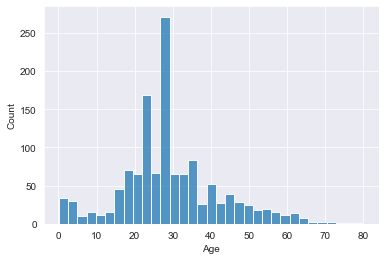

In [126]:
sns.histplot(df['Age'])

In [127]:
df.drop('Age_cuts', axis=1, inplace=True)
cut_bins = [0, 15, 20, 25, 30, 40, 50, 60, 100]
df['Age'] = pd.cut(df['Age'], bins=cut_bins, right=False)

In [128]:
encoder = LabelEncoder()
df['Age'] = encoder.fit_transform(df['Age'])

In [129]:
df

,Survived,Age,SibSp,Parch,Fare,Embarked,Title,Pclass3,Pclass2,Male
PassengerId,,,,,,,,,,
1,0.0,2,1,0,7.2500,S,Middle-aged man,0.0,1.0,1.0
2,1.0,4,1,0,71.2833,C,Middle-aged woman,0.0,0.0,0.0
3,1.0,3,0,0,7.9250,S,Young woman,0.0,1.0,0.0
4,1.0,4,1,0,53.1000,S,Middle-aged woman,0.0,0.0,0.0
5,0.0,4,0,0,8.0500,S,Middle-aged man,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1305,NaN,3,0,0,8.0500,S,Middle-aged man,0.0,1.0,1.0
1306,NaN,4,0,0,108.9000,C,Middle-aged woman,0.0,0.0,0.0
1307,NaN,4,0,0,7.2500,S,Middle-aged man,0.0,1.0,1.0


* _Fare_

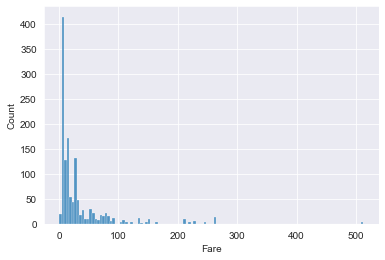

In [130]:
sns.histplot(df['Fare'])

In this histogram we can see that there are several outliers around 500.\
Let's separate this variable in bins minimizing the loss of information on the major area (0-50$) 

In [131]:
cut_bins = [0, 10, 20, 30, 40, 50, 75, 100, 200, 300, 600]
df['Fare'] = pd.cut(df['Fare'], bins=cut_bins, right=False)

In [132]:
df['Fare'] = encoder.fit_transform(df['Fare'])

In [133]:
df

,Survived,Age,SibSp,Parch,Fare,Embarked,Title,Pclass3,Pclass2,Male
PassengerId,,,,,,,,,,
1,0.0,2,1,0,0,S,Middle-aged man,0.0,1.0,1.0
2,1.0,4,1,0,5,C,Middle-aged woman,0.0,0.0,0.0
3,1.0,3,0,0,0,S,Young woman,0.0,1.0,0.0
4,1.0,4,1,0,5,S,Middle-aged woman,0.0,0.0,0.0
5,0.0,4,0,0,0,S,Middle-aged man,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1305,NaN,3,0,0,0,S,Middle-aged man,0.0,1.0,1.0
1306,NaN,4,0,0,7,C,Middle-aged woman,0.0,0.0,0.0
1307,NaN,4,0,0,0,S,Middle-aged man,0.0,1.0,1.0


* _Embarked_

In [134]:
onehot_embarked = pd.DataFrame(onehot.fit_transform(df[['Embarked']], ).toarray(), index=range(1,1310), columns=['Embarked_Q', 'Embarked_S'])
df = df.join(onehot_embarked)
df.drop('Embarked', axis=1, inplace=True)

In [135]:
df

,Survived,Age,SibSp,Parch,Fare,Title,Pclass3,Pclass2,Male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,0.0,2,1,0,0,Middle-aged man,0.0,1.0,1.0,0.0,1.0
2,1.0,4,1,0,5,Middle-aged woman,0.0,0.0,0.0,0.0,0.0
3,1.0,3,0,0,0,Young woman,0.0,1.0,0.0,0.0,1.0
4,1.0,4,1,0,5,Middle-aged woman,0.0,0.0,0.0,0.0,1.0
5,0.0,4,0,0,0,Middle-aged man,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,3,0,0,0,Middle-aged man,0.0,1.0,1.0,0.0,1.0
1306,NaN,4,0,0,7,Middle-aged woman,0.0,0.0,0.0,0.0,0.0
1307,NaN,4,0,0,0,Middle-aged man,0.0,1.0,1.0,0.0,1.0


* _Title_

In [136]:
onehot_title = pd.DataFrame(onehot.fit_transform(df[['Title']], ).toarray(), index=range(1,1310), columns=['Middle W', 'Prestigious', 'Young M', 'Young W'])
df = df.join(onehot_title)
df.drop('Title', axis=1, inplace=True)

In [137]:
df

,Survived,Age,SibSp,Parch,Fare,Pclass3,Pclass2,Male,Embarked_Q,Embarked_S,Middle W,Prestigious,Young M,Young W
PassengerId,,,,,,,,,,,,,,
1,0.0,2,1,0,0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,4,1,0,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,3,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,4,1,0,5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5,0.0,4,0,0,0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,3,0,0,0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1306,NaN,4,0,0,7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1307,NaN,4,0,0,0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


## Model

In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [139]:
X_train = df.iloc[:891].drop('Survived', axis=1)
y_train = df.iloc[:891]['Survived']
X_test = df.iloc[891:].drop('Survived', axis=1)

In [140]:
solution = pd.read_csv(r'C:\Users\Alexandre\Desktop\Machine Learning\Datasets\titanic\solution.csv')

### Logistic Regression

In [221]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'penalty': ['l1', 'l2'], 
              'solver':['newton-cg', 'lbfgs', 'liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid)
grid.fit(X_train, y_train);

In [222]:
grid.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}

In [223]:
log = LogisticRegression(C=1, penalty='l2', solver='newton-cg')
log.fit(X_train, y_train)
pred_log = log.predict(X_test)
score_log = metrics.accuracy_score(solution, pred_log)

print(confusion_matrix(solution, pred_log))
print('\n')
print(classification_report(solution, pred_log))
print('\n')
print("Accuracy:",metrics.accuracy_score(solution, pred_log))

[[205  55]
 [ 44 114]]


              precision    recall  f1-score   support

           0       0.82      0.79      0.81       260
           1       0.67      0.72      0.70       158

    accuracy                           0.76       418
   macro avg       0.75      0.75      0.75       418
weighted avg       0.77      0.76      0.76       418



Accuracy: 0.7631578947368421


### Support Vector Classifier

In [217]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma':[1, 0.1, 0.01, 0.001, 0.0001]}
grid = GridSearchCV(SVC(), param_grid)
grid.fit(X_train, y_train);

In [218]:
grid.best_params_

{'C': 100, 'gamma': 0.01}

In [195]:
svc = SVC(C=100, gamma=0.01)
svc.fit(X_train, y_train)

pred_svc = grid.predict(X_test)
score_svc = metrics.accuracy_score(solution, pred_svc)

print(confusion_matrix(solution, pred_svc))
print('\n')
print(classification_report(solution, pred_svc))
print('\n')
print("Accuracy:",metrics.accuracy_score(solution, pred_svc))

[[212  48]
 [ 44 114]]


              precision    recall  f1-score   support

           0       0.83      0.82      0.82       260
           1       0.70      0.72      0.71       158

    accuracy                           0.78       418
   macro avg       0.77      0.77      0.77       418
weighted avg       0.78      0.78      0.78       418



Accuracy: 0.7799043062200957


### K Nearest Neighbors


In [245]:
param_grid = {'n_neighbors': np.arange(1,50), 
              'p':[1, 2, 3]}
grid = GridSearchCV(KNeighborsClassifier(), param_grid)
grid.fit(X_train, y_train);

In [244]:
grid.best_params_

{'n_neighbors': 29, 'p': 1}

In [247]:
knn = KNeighborsClassifier(n_neighbors=29, p=1)
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)
score_knn = metrics.accuracy_score(solution, pred_knn)

print(confusion_matrix(solution, pred_knn))
print('\n')
print(classification_report(solution, pred_knn))
print('\n')
print("Accuracy:",metrics.accuracy_score(solution, pred_knn))

[[211  49]
 [ 59  99]]


              precision    recall  f1-score   support

           0       0.78      0.81      0.80       260
           1       0.67      0.63      0.65       158

    accuracy                           0.74       418
   macro avg       0.73      0.72      0.72       418
weighted avg       0.74      0.74      0.74       418



Accuracy: 0.7416267942583732


### Gaussian Naive Bayes

In [248]:
gaussian = GaussianNB() # No hyperparameters to tune
gaussian.fit(X_train, y_train)
pred_nb = gaussian.predict(X_test)
score_nb = metrics.accuracy_score(solution, pred_nb)

print(confusion_matrix(solution, pred_nb))
print('\n')
print(classification_report(solution, pred_nb))
print('\n')
print("Accuracy:",metrics.accuracy_score(solution, pred_nb))

[[195  65]
 [ 43 115]]


              precision    recall  f1-score   support

           0       0.82      0.75      0.78       260
           1       0.64      0.73      0.68       158

    accuracy                           0.74       418
   macro avg       0.73      0.74      0.73       418
weighted avg       0.75      0.74      0.74       418



Accuracy: 0.7416267942583732


### Perceptron

In [269]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)
pred_perceptron = perceptron.predict(X_test)
score_perceptron = metrics.accuracy_score(solution, pred_perceptron)

print(confusion_matrix(solution, pred_perceptron))
print('\n')
print(classification_report(solution, pred_perceptron))
print('\n')
print("Accuracy:",metrics.accuracy_score(solution, pred_perceptron))

[[ 96 164]
 [ 22 136]]


              precision    recall  f1-score   support

           0       0.81      0.37      0.51       260
           1       0.45      0.86      0.59       158

    accuracy                           0.56       418
   macro avg       0.63      0.61      0.55       418
weighted avg       0.68      0.56      0.54       418



Accuracy: 0.5550239234449761


### Linear SVC

In [277]:
param_grid = {'C': [0.1, 1, 10], 
              'penalty': ['l1', 'l2'], 
              'loss': ['hinge', 'squared_hinge'], 
              'multi_class': ['ovr','crammer_singer']}
grid = GridSearchCV(LinearSVC(), param_grid)
grid.fit(X_train, y_train);

In [278]:
grid.best_params_

{'C': 1, 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2'}

In [279]:
linear_svc = LinearSVC(C=1, loss= 'hinge', penalty= 'l2', multi_class='ovr')
linear_svc.fit(X_train, y_train)
pred_Lsvc = linear_svc.predict(X_test)
score_Lsvc = metrics.accuracy_score(solution, pred_Lsvc)

print(confusion_matrix(solution, pred_Lsvc))
print('\n')
print(classification_report(solution, pred_Lsvc))
print('\n')
print("Accuracy:",metrics.accuracy_score(solution, pred_Lsvc))

[[210  50]
 [ 45 113]]


              precision    recall  f1-score   support

           0       0.82      0.81      0.82       260
           1       0.69      0.72      0.70       158

    accuracy                           0.77       418
   macro avg       0.76      0.76      0.76       418
weighted avg       0.77      0.77      0.77       418



Accuracy: 0.7727272727272727


### Stochastic Gradient Descent

In [281]:
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'], 
              'loss': ['hinge', 'log']}
grid = GridSearchCV(SGDClassifier(), param_grid)
grid.fit(X_train, y_train);

In [283]:
grid.best_params_

{'loss': 'hinge', 'penalty': 'l1'}

In [305]:
sgd = SGDClassifier(loss='hinge', penalty='l2')
sgd.fit(X_train, y_train)
pred_sgd = sgd.predict(X_test)
score_sgd = metrics.accuracy_score(solution, pred_sgd)

print(confusion_matrix(solution, pred_sgd))
print('\n')
print(classification_report(solution, pred_sgd))
print('\n')
print("Accuracy:",metrics.accuracy_score(solution, pred_sgd))

[[211  49]
 [ 44 114]]


              precision    recall  f1-score   support

           0       0.83      0.81      0.82       260
           1       0.70      0.72      0.71       158

    accuracy                           0.78       418
   macro avg       0.76      0.77      0.76       418
weighted avg       0.78      0.78      0.78       418



Accuracy: 0.777511961722488


### Decision Tree

In [331]:
param_grid = {'criterion': ["gini", "entropy"], 
              'splitter': ["best", "random"],
              'max_depth': np.arange(1,10),
              'min_samples_split': np.arange(1,10),
              'min_samples_leaf': np.arange(1,10),
             }
grid = GridSearchCV(DecisionTreeClassifier(), param_grid)
grid.fit(X_train, y_train);

In [332]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 7,
 'min_samples_split': 7,
 'splitter': 'best'}

In [347]:
decision_tree = DecisionTreeClassifier(criterion='gini', 
                                       max_depth=4, 
                                       splitter='random',
                                       min_samples_leaf=3,
                                       min_samples_split=6)
decision_tree.fit(X_train, y_train)
pred_tree = decision_tree.predict(X_test)
score_tree = metrics.accuracy_score(solution, pred_tree)

print(confusion_matrix(solution, pred_tree))
print('\n')
print(classification_report(solution, pred_tree))
print('\n')
print("Accuracy:",metrics.accuracy_score(solution, pred_tree))

[[237  23]
 [ 67  91]]


              precision    recall  f1-score   support

           0       0.78      0.91      0.84       260
           1       0.80      0.58      0.67       158

    accuracy                           0.78       418
   macro avg       0.79      0.74      0.75       418
weighted avg       0.79      0.78      0.78       418



Accuracy: 0.784688995215311


### Random Forest Classifier

In [357]:
param_grid = {'n_estimators': [100, 200, 400], 
              'max_depth': np.linspace(10, 110, 11),
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
             }
grid = GridSearchCV(RandomForestClassifier(), param_grid)
grid.fit(X_train, y_train);

In [358]:
grid.best_params_

{'max_depth': 10.0,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 200}

In [364]:
random_forest = RandomForestClassifier(max_depth=10.0,
                                       min_samples_leaf=4,
                                       min_samples_split=5,
                                       n_estimators=200)
random_forest.fit(X_train, y_train)
pred_rfc = random_forest.predict(X_test)
score_rfc = metrics.accuracy_score(solution, pred_rfc)

print(confusion_matrix(solution, pred_rfc))
print('\n')
print(classification_report(solution, pred_rfc))
print('\n')
print("Accuracy:",metrics.accuracy_score(solution, pred_rfc))

[[222  38]
 [ 54 104]]


              precision    recall  f1-score   support

           0       0.80      0.85      0.83       260
           1       0.73      0.66      0.69       158

    accuracy                           0.78       418
   macro avg       0.77      0.76      0.76       418
weighted avg       0.78      0.78      0.78       418



Accuracy: 0.7799043062200957


### XGBoost

In [366]:
param_grid = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
              "max_depth": [ 3, 4, 5, 6, 8, 10, 12, 15],
              "min_child_weight": [ 1, 3, 5, 7 ],
              "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
              "colsample_bytree": [ 0.3, 0.4, 0.5 , 0.7 ] 
             }
grid = GridSearchCV(XGBClassifier(), param_grid)
grid.fit(X_train, y_train);

In [367]:
grid.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.0,
 'learning_rate': 0.2,
 'max_depth': 8,
 'min_child_weight': 5}

In [371]:
xgb = XGBClassifier(colsample_bytree=0.5,
                    gamma=0.0,
                    learning_rate=0.2,
                    max_depth=8,
                    min_child_weight=5)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
score_xgb = metrics.accuracy_score(solution, pred_xgb)

print(confusion_matrix(solution, pred_xgb))
print('\n')
print(classification_report(solution, pred_xgb))
print('\n')
print("Accuracy:",metrics.accuracy_score(solution, pred_xgb))

[[216  44]
 [ 53 105]]


              precision    recall  f1-score   support

           0       0.80      0.83      0.82       260
           1       0.70      0.66      0.68       158

    accuracy                           0.77       418
   macro avg       0.75      0.75      0.75       418
weighted avg       0.77      0.77      0.77       418



Accuracy: 0.7679425837320574


In [372]:
dictionary = {
    'Logistic Regression': score_log,
    'Support Vector Classifier': score_svc,
    'K Nearest Neighbors': score_knn,
    'Gaussian Naive Bayes': score_nb,
    'Perceptron': score_perceptron,
    'Linear SVC': score_Lsvc,
    'Stochastic Gradient Descent': score_sgd,
    'Decision Tree': score_tree,
    'Random Forest Classifier': score_rfc,
    'XGBoost Classifier': score_xgb
}

score_table = pd.DataFrame(data=dictionary.values(), columns=['Score'], index=dictionary.keys())
score_table.sort_values(by='Score', ascending=False)

,Score
Decision Tree,0.784689
Support Vector Classifier,0.779904
Random Forest Classifier,0.779904
Stochastic Gradient Descent,0.777512
Linear SVC,0.772727
XGBoost Classifier,0.767943
Logistic Regression,0.763158
K Nearest Neighbors,0.741627
Gaussian Naive Bayes,0.741627
Perceptron,0.555024


In [373]:
submission = pd.DataFrame()
submission['PassengerId'] = X_test.index
submission['Survived'] = pred_svc
submission.to_csv('./output/submission.csv', index=False)

## Potential improvements

* Instead of simply filling age NA's with medians, use a distribution of each title
* If passengers have a similar number in the ticket, similar fare price and Pclass, they were probably in the same Cabin section. 
* Create a family size feature combining Parch and SibSp
* Create a isAlone column, not having to worry about your family during scape might help
* Add AUC curve to parameter tunning
* Why does Stochastic Gradient Descent changes the score so much?

## Comments

* Label encoder in Fare made the very high numbers less important?
* Should I drop the first column in OneHotEncoding?
* Is it okay that label encoder starts with 0?
* How do I know how the data should be preprocessed for each algorithm?